This is work in progress.

## Setup

In [1]:
import sys
sys.path.insert(0, '..')
import cProfile
import numpy as np; print('numpy', np.__version__)
import zarr; print('zarr', zarr.__version__, 'blosc', ' '.join(zarr.blosc_version()))
import bcolz; print('bcolz', bcolz.__version__, 'blosc', ' '.join(bcolz.blosc_version()))
import dask; print('dask', dask.__version__)
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, visualize
from cachey import nbytes
import bokeh
from bokeh.io import output_notebook
output_notebook()
import allel
from allel.chunked.storage_hdf5 import h5fmem
from multiprocessing.pool import ThreadPool

numpy 1.11.0
zarr 0.3.1.dev8 blosc 1.8.1 $Date:: 2016-04-08 #$
bcolz 1.0.0 blosc 1.8.1 $Date:: 2016-04-08 #$
dask 0.8.1


Loading BokehJS ...

In [2]:
def chunked_copy(source, target, chunklen):
    """Copy data from `source` to `target` in 1D chunks of size `chunklen`."""
    for i in range(0, source.shape[0], chunklen):
        target[i:i+chunklen] = source[i:i+chunklen]
        

In [3]:
def chunked_apply(f, source, target, chunklen):
    """Copy data from `source` to `target` in 1D chunks of size `chunklen`."""
    for i in range(0, source.shape[0], chunklen):
        target[i:i+chunklen] = f(source[i:i+chunklen])
        

In [4]:
def dask_copy(source, target, chunks, lock=True, get=dask.threaded.get, num_workers=2, profile=False, dt=0.1):
    """Copy data from `source` to `target` using dask."""
    
    source = da.from_array(source, chunks=chunks, name='source')
    run = lambda: da.store(source, target, lock=lock, get=get, num_workers=num_workers)
        
    if profile:
        with Profiler() as prof, ResourceProfiler(dt=dt) as rprof:
            run()
        visualize([prof, rprof])
    else:
        run()
        

In [5]:
def dask_apply(f, source, target, chunks, lock=True, get=dask.threaded.get, num_workers=2, profile=False, dt=0.1):
    """Copy data from `source` to `target` using dask."""
    
    source = da.from_array(source, chunks=chunks, name='source')
    result = f(source)
    run = lambda: da.store(result, target, lock=lock, get=get, num_workers=num_workers)
        
    if profile:
        with Profiler() as prof, ResourceProfiler(dt=dt) as rprof:
            run()
        visualize([prof, rprof])
    else:
        run()
        

In [18]:
# create some numpy arrays
a1 = np.arange(1e8, dtype='i4')
a2 = np.empty_like(a1)
a3 = np.empty_like(a1, dtype='f4')

In [8]:
# create some in-memory HDF5 datasets
h5f = h5fmem()
chunklen = 2**20  # use 4M chunks
h1 = h5f.create_dataset('h1', data=a1, chunks=(chunklen,), 
                        compression='gzip', compression_opts=1, shuffle=True)
h2 = h5f.create_dataset('h2', shape=h1.shape, dtype=h1.dtype, chunks=h1.chunks, 
                        compression=h1.compression, compression_opts=h1.compression_opts, shuffle=h1.shuffle)
h3 = h5f.create_dataset('h3', shape=h1.shape, dtype='f4', chunks=h1.chunks, 
                        compression=h1.compression, compression_opts=h1.compression_opts, shuffle=h1.shuffle)

In [9]:
z1 = zarr.array(a1, chunks=chunklen, cname='zlib', clevel=1, shuffle=1)
z1

zarr.ext.SynchronizedArray((100000000,), int32, chunks=(1048576,))
  cname: zlib; clevel: 1; shuffle: 1 (BYTESHUFFLE)
  nbytes: 381.5M; cbytes: 3.6M; ratio: 105.2; initialized: 96/96

In [10]:
z2 = zarr.empty(z1.shape, chunks=z1.chunks, dtype=z1.dtype, cname=z1.cname, clevel=z1.clevel, shuffle=z1.shuffle)
z2

zarr.ext.SynchronizedArray((100000000,), int32, chunks=(1048576,))
  cname: zlib; clevel: 1; shuffle: 1 (BYTESHUFFLE)
  nbytes: 381.5M; cbytes: 0; initialized: 0/96

In [11]:
z3 = zarr.empty(z1.shape, chunks=z1.chunks, dtype='f4', cname=z1.cname, clevel=z1.clevel, shuffle=z1.shuffle)
z3

zarr.ext.SynchronizedArray((100000000,), float32, chunks=(1048576,))
  cname: zlib; clevel: 1; shuffle: 1 (BYTESHUFFLE)
  nbytes: 381.5M; cbytes: 0; initialized: 0/96

In [12]:
c1 = bcolz.carray(a1, chunklen=chunklen, cparams=bcolz.cparams(cname='zlib', clevel=1, shuffle=1))
c1

carray((100000000,), int32)
  nbytes: 381.47 MB; cbytes: 7.61 MB; ratio: 50.13
  cparams := cparams(clevel=1, shuffle=1, cname='zlib')
[       0        1        2 ..., 99999997 99999998 99999999]

In [13]:
c2 = bcolz.zeros(c1.shape, dtype=c1.dtype, chunklen=c1.chunklen, cparams=c1.cparams)
c2

carray((100000000,), int32)
  nbytes: 381.47 MB; cbytes: 4.02 MB; ratio: 94.95
  cparams := cparams(clevel=1, shuffle=1, cname='zlib')
[0 0 0 ..., 0 0 0]

In [14]:
c3 = bcolz.zeros(c1.shape, dtype='f4', chunklen=c1.chunklen, cparams=c1.cparams)
c3

carray((100000000,), float32)
  nbytes: 381.47 MB; cbytes: 4.02 MB; ratio: 94.95
  cparams := cparams(clevel=1, shuffle=1, cname='zlib')
[ 0.  0.  0. ...,  0.  0.  0.]

In [15]:
import timeit

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/media/aliman/SD1/pyenv/zarr_py34/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Copy

In [17]:
def benchmark_copy(x, y, lock=True, repeat=5, title=None):
    
    stmt = lambda: chunked_copy(x, y, chunklen)
    r1 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    stmt = lambda: dask_copy(x, y, chunklen, get=dask.async.get_sync, lock=lock)
    r2 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    stmt = lambda: dask_copy(x, y, chunklen, get=dask.threaded.get, num_workers=1, lock=lock)
    r3 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    stmt = lambda: dask_copy(x, y, chunklen, get=dask.threaded.get, num_workers=2, lock=lock)
    r4 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    stmt = lambda: dask_copy(x, y, chunklen, get=dask.threaded.get, num_workers=3, lock=lock)
    r5 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    sns.swarmplot(data=[r1, r2, r3, r4, r5])
    plt.gca().set_xticklabels(['chunked', 
                               'dask sync', 
                               'dask threaded, 1 worker', 
                               'dask threaded, 2 workers',
                               'dask threaded, 3 workers'], 
                              rotation=90)
    plt.gca().set_ylabel('Time (s)')
    plt.gca().set_xlabel('Execution method')
    if title:
        plt.gca().set_title(title)
    
    

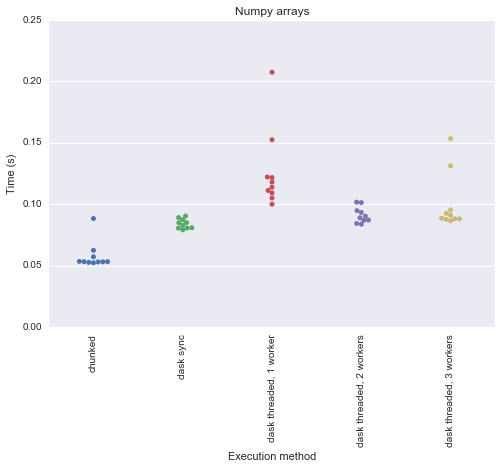

In [90]:
benchmark_copy(a1, a2, title='Numpy arrays', repeat=10)

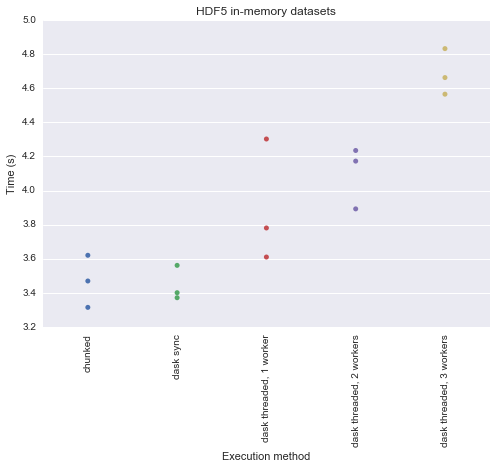

In [93]:
benchmark_copy(h1, h2, title='HDF5 in-memory datasets', repeat=3)

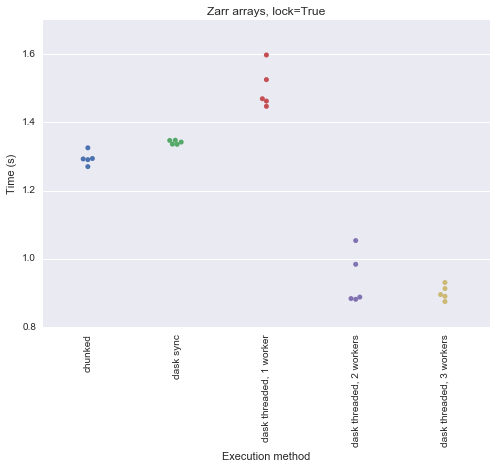

In [91]:
benchmark_copy(z1, z2, title='Zarr arrays, lock=True', repeat=5, lock=True)

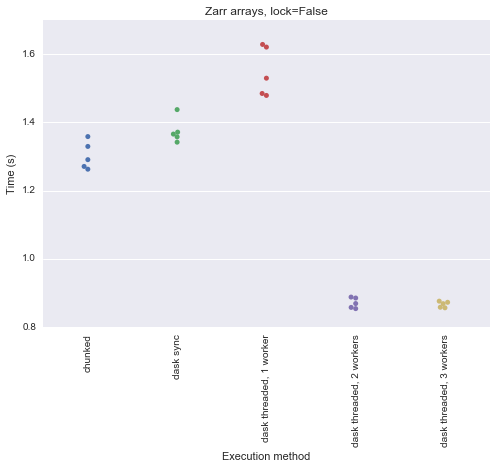

In [92]:
benchmark_copy(z1, z2, title='Zarr arrays, lock=False', repeat=5, lock=False)

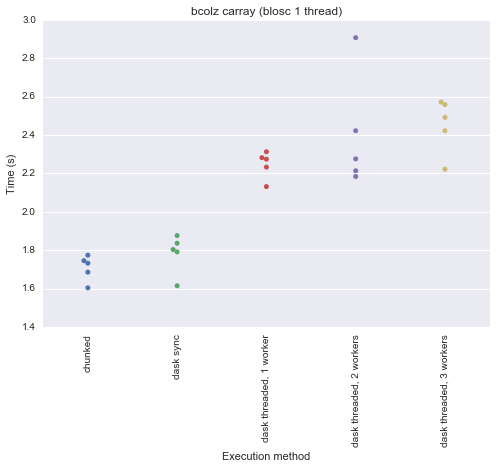

In [94]:
bcolz.blosc_set_nthreads(1)
benchmark_copy(c1, c2, title='bcolz carray (blosc 1 thread)', repeat=5)

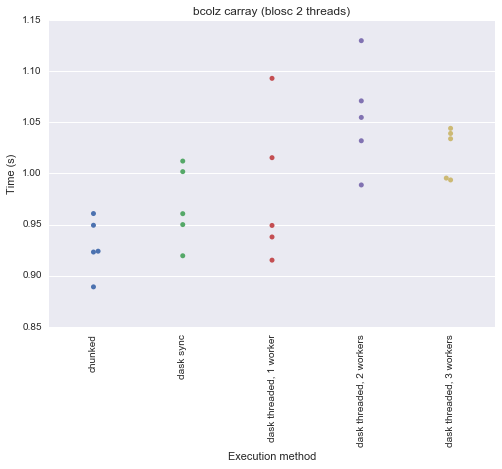

In [95]:
bcolz.blosc_set_nthreads(2)
benchmark_copy(c1, c2, title='bcolz carray (blosc 2 threads)', repeat=5)

## Linear

In [28]:
def benchmark_apply(f, x, y, lock=True, repeat=5, title=None, df=None):
    
    if df is None:
        df = f
        
    stmt = lambda: chunked_apply(f, x, y, chunklen)
    r1 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    stmt = lambda: dask_apply(df, x, y, chunklen, get=dask.async.get_sync, lock=lock)
    r2 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    stmt = lambda: dask_apply(df, x, y, chunklen, get=dask.threaded.get, num_workers=1, lock=lock)
    r3 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    stmt = lambda: dask_apply(df, x, y, chunklen, get=dask.threaded.get, num_workers=2, lock=lock)
    r4 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    stmt = lambda: dask_apply(df, x, y, chunklen, get=dask.threaded.get, num_workers=3, lock=lock)
    r5 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    stmt = lambda: dask_apply(df, x, y, chunklen, get=dask.threaded.get, num_workers=4, lock=lock)
    r6 = timeit.repeat(stmt, repeat=repeat, number=1)
    
    sns.swarmplot(data=[r1, r2, r3, r4, r5, r6])
    plt.gca().set_xticklabels(['chunked', 
                               'dask sync', 
                               'dask threaded, 1 worker', 
                               'dask threaded, 2 workers',
                               'dask threaded, 3 workers',
                               'dask threaded, 4 workers',
                              ], 
                              rotation=90)
    plt.gca().set_ylabel('Time (s)')
    plt.gca().set_xlabel('Execution method')
    if title:
        plt.gca().set_title(title)
    
    

In [36]:
linear = lambda x: 3*x + 4

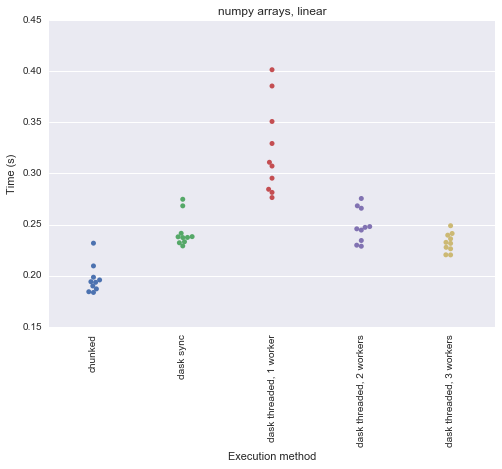

In [44]:
benchmark_apply(linear, a1, a2, repeat=10, title='numpy arrays, linear')

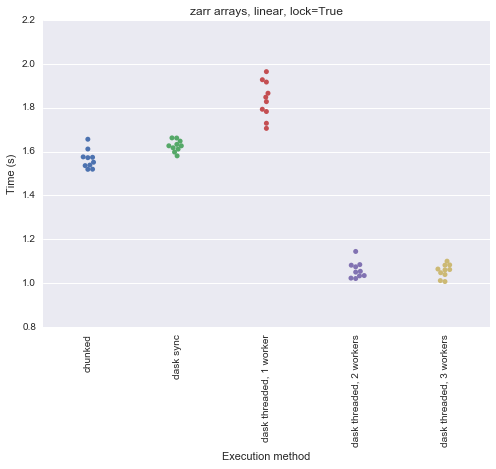

In [62]:
benchmark_apply(linear, z1, z2, repeat=10, lock=True, title='zarr arrays, linear, lock=True')

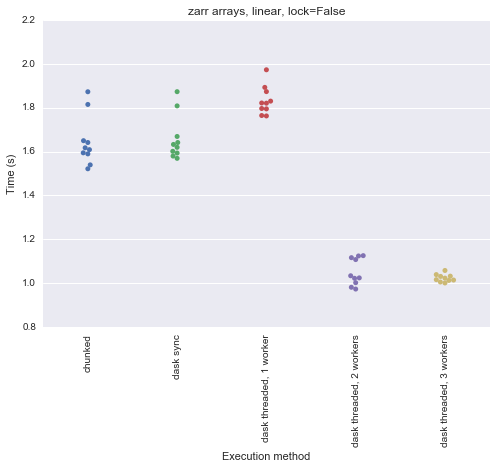

In [46]:
benchmark_apply(linear, z1, z2, repeat=10, lock=False, title='zarr arrays, linear, lock=False')

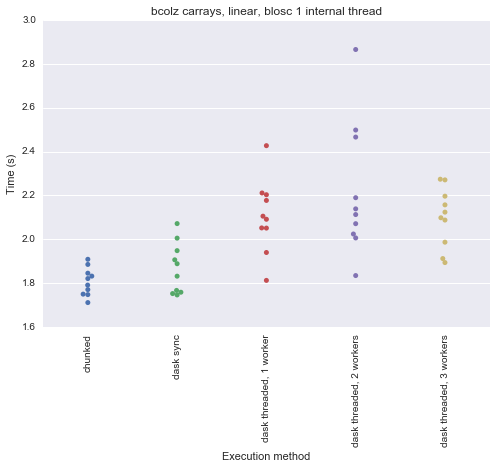

In [47]:
bcolz.blosc_set_nthreads(1)
benchmark_apply(linear, c1, c2, repeat=10, title='bcolz carrays, linear, blosc 1 internal thread')

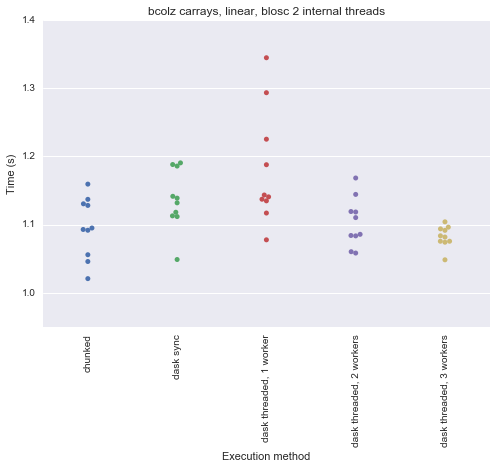

In [48]:
bcolz.blosc_set_nthreads(2)
benchmark_apply(linear, c1, c2, repeat=10, title='bcolz carrays, linear, blosc 2 internal threads')

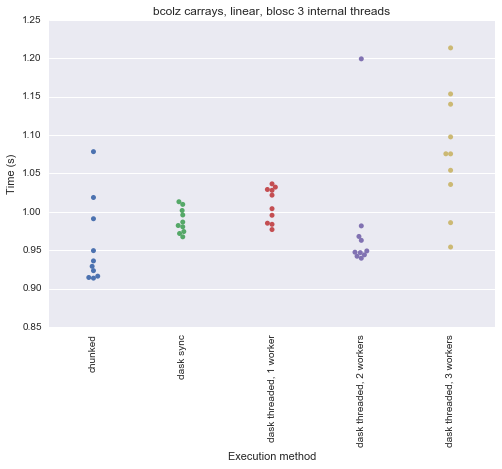

In [49]:
bcolz.blosc_set_nthreads(3)
benchmark_apply(linear, c1, c2, repeat=10, title='bcolz carrays, linear, blosc 3 internal threads')

## Trig

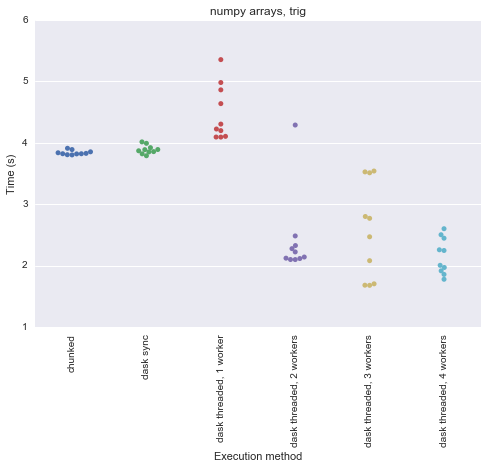

In [44]:
benchmark_apply(np.sin, a1, a3, df=da.sin, repeat=10, title='numpy arrays, trig')

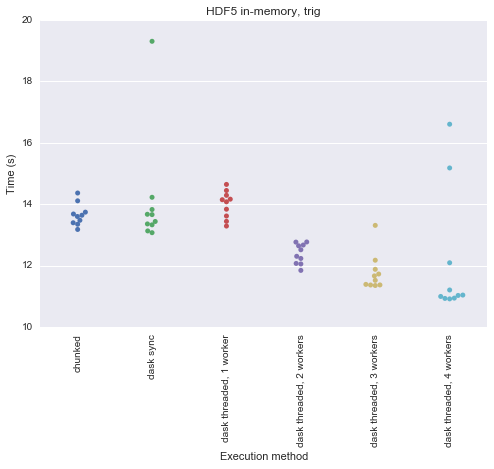

In [45]:
benchmark_apply(np.sin, h1, h3, df=da.sin, repeat=10, title='HDF5 in-memory, trig')

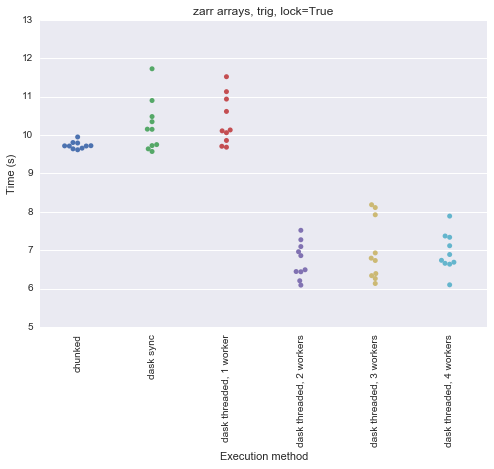

In [46]:
benchmark_apply(np.sin, z1, z3, df=da.sin, repeat=10, title='zarr arrays, trig, lock=True', lock=True)

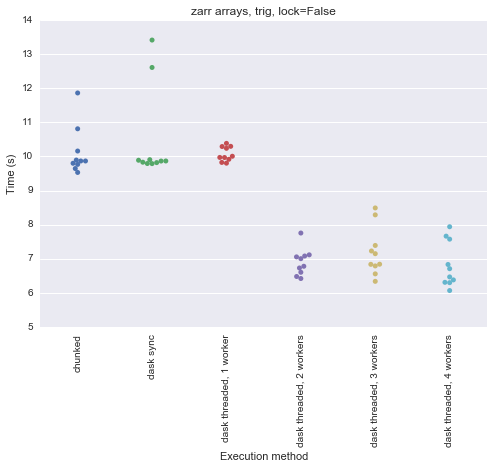

In [47]:
benchmark_apply(np.sin, z1, z3, df=da.sin, repeat=10, title='zarr arrays, trig, lock=False', lock=False)

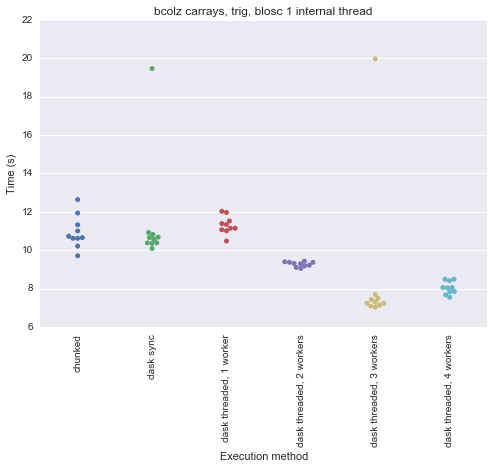

In [48]:
bcolz.blosc_set_nthreads(1)
benchmark_apply(np.sin, c1, c3, df=da.sin, repeat=10, title='bcolz carrays, trig, blosc 1 internal thread')

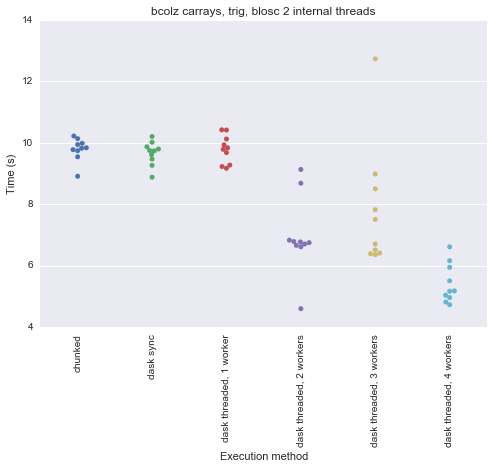

In [49]:
bcolz.blosc_set_nthreads(2)
benchmark_apply(np.sin, c1, c3, df=da.sin, repeat=10, title='bcolz carrays, trig, blosc 2 internal threads')

## Sandbox

In [15]:
x = da.from_array(a1, chunks=2**19, name='foo')
x

dask.array<foo, shape=(100000000,), dtype=int32, chunksize=(524288,)>

In [17]:
y = da.sin(x)

In [19]:
%time y.compute()

CPU times: user 5.33 s, sys: 184 ms, total: 5.52 s
Wall time: 1.6 s


array([ 0.        ,  0.84147098,  0.90929743, ..., -0.87103474,
       -0.05727351,  0.80914472])

In [20]:
%time np.sin(a1)

CPU times: user 3.8 s, sys: 36 ms, total: 3.83 s
Wall time: 3.83 s


array([ 0.        ,  0.84147098,  0.90929743, ..., -0.87103474,
       -0.05727351,  0.80914472])

In [21]:
z = np.sin(a1)
z

array([ 0.        ,  0.84147098,  0.90929743, ..., -0.87103474,
       -0.05727351,  0.80914472])

In [22]:
%time zarr.array(z, chunks=2**20, cname='zlib', clevel=1, shuffle=1)

CPU times: user 10.8 s, sys: 196 ms, total: 11 s
Wall time: 11 s


zarr.ext.SynchronizedArray((100000000,), float64, chunks=(1048576,))
  cname: zlib; clevel: 1; shuffle: 1 (BYTESHUFFLE)
  nbytes: 762.9M; cbytes: 560.3M; ratio: 1.4; initialized: 96/96

In [23]:
%time z2[:] = z

CPU times: user 608 ms, sys: 8 ms, total: 616 ms
Wall time: 613 ms


In [25]:
z2[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [24]:
bcolz.blosc_set_nthreads(3)
%time bcolz.carray(z, chunklen=2**20, cparams=bcolz.cparams(cname='zlib', clevel=1, shuffle=1))

CPU times: user 16.2 s, sys: 2.42 s, total: 18.6 s
Wall time: 6.65 s


carray((100000000,), float64)
  nbytes: 762.94 MB; cbytes: 566.15 MB; ratio: 1.35
  cparams := cparams(clevel=1, shuffle=1, cname='zlib')
[ 0.          0.84147098  0.90929743 ..., -0.87103474 -0.05727351
  0.80914472]